## EL-GY-9133 Machine Learning for Cyber-Security
### Lab 1: E-mail Spam Filtering
##### Release Date: 02/22/2018; Due Date: Midnight, 03/09/2018

Student Name: Manuel Serrano Rebuelta

Student Netid: msr542

In [1]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import glob
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.model_selection import KFold
from collections import defaultdict #Allows duplicate keys in dictionary
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Load all emails and labels in a data frame ###

data_train = pd.DataFrame(columns=['X', 'y'])
data_test = pd.DataFrame(columns=['X', 'y'])
count_train = 0
count_test = 0

#Iterate over the 9 folds
for i in range(1, 11):
    #Load spam emails
    for spam_path in glob.glob('lingspam_public/lemm_stop/part'+str(i)+'/spm*.txt'):
        with open(spam_path, 'r') as spam_file:
            opened_spam_file = spam_file.read().replace('\n', '')
            if(i==10):
                data_test.loc[count_test] = [opened_spam_file, 1]
                count_test += 1
            else:
                data_train.loc[count_train] = [opened_spam_file, 1]
                count_train += 1
            
    #Load legitimate emails
    for legit_path in glob.glob('lingspam_public/lemm_stop/part'+str(i)+'/[!spm]*.txt'):
        with open(legit_path, 'r') as legit_file:
            opened_legit_file = legit_file.read().replace('\n', '')
            if(i==10):
                data_test.loc[count_test] = [opened_legit_file, 0]
                count_test += 1
            else:
                data_train.loc[count_train] = [opened_legit_file, 0]
                count_train += 1

In [3]:
### Manually create our document-term matrix (binary, since we are not counting terms)
### Then, we calculate information gain of all terms within the dataset

CV = CountVectorizer(binary=True)
X_vectorized = CV.fit_transform(data_train['X'])
info_gain_features = dict(zip(CV.get_feature_names(), mutual_info_classif(X_vectorized, data_train['y'].tolist())))

In [4]:
# Print 10 terms with higher information gain
sorted(info_gain_features, key=info_gain_features.get)[-10:]

['business',
 'our',
 'market',
 'click',
 'money',
 'university',
 'linguistic',
 'free',
 'remove',
 'language']

In [5]:
# Print 100 terms with higher information gain
sorted(info_gain_features, key=info_gain_features.get)[-100:]

['analysis',
 'marketing',
 'xxx',
 'security',
 'fresh',
 'study',
 'workshop',
 'wait',
 'need',
 'mlm',
 'simply',
 'online',
 'friend',
 'structure',
 'deadline',
 'week',
 'huge',
 'science',
 'dream',
 'ad',
 'anywhere',
 'financial',
 'grammar',
 'department',
 'toll',
 'investment',
 'live',
 'sale',
 'zip',
 'syntax',
 'start',
 'credit',
 'discussion',
 'amaze',
 'ever',
 'bonus',
 'receive',
 'pay',
 'here',
 'watch',
 'yours',
 'speaker',
 'conference',
 'fun',
 'success',
 'month',
 'profit',
 'abstract',
 'offer',
 'customer',
 'hour',
 'earn',
 'theory',
 'linguist',
 'hundred',
 'papers',
 'yourself',
 'com',
 'll',
 'service',
 'edu',
 'mailing',
 '100',
 'every',
 'over',
 'dollar',
 'cost',
 'bulk',
 'day',
 'want',
 'win',
 'cash',
 'buy',
 'purchase',
 'check',
 'best',
 'save',
 'thousand',
 'guarantee',
 'easy',
 'income',
 'linguistics',
 'english',
 'internet',
 'million',
 'company',
 'sell',
 'product',
 'advertise',
 'today',
 'business',
 'our',
 'market',


In [6]:
# Print 1000 terms with higher information gain
sorted(info_gain_features, key=info_gain_features.get)[-1000:]

['exceedingly',
 'favourite',
 'friends',
 '149',
 '199',
 'install',
 'convince',
 'debate',
 'up',
 'function',
 'represent',
 'identify',
 '436',
 'bargain',
 'competitor',
 'gay',
 'mouse',
 'paradise',
 'sleep',
 'encourage',
 'dave',
 'utility',
 'compuserve',
 'payment',
 'generally',
 'scope',
 'susan',
 'prof',
 'using',
 'en',
 'successful',
 'fl',
 'radio',
 'error',
 'happy',
 'flame',
 'kid',
 'functional',
 'call',
 'dr',
 'loan',
 'various',
 'address',
 'movement',
 'chomsky',
 'mouton',
 'nlp',
 'largest',
 'within',
 'school',
 '10',
 'promise',
 'contrast',
 'reception',
 'everyday',
 'november',
 'philosophy',
 'biggest',
 'extremely',
 'assumption',
 'bibliography',
 'panel',
 'spain',
 'asset',
 'grow',
 '1999',
 'publish',
 'average',
 'accompany',
 'edinburgh',
 'parse',
 'pronoun',
 'obviously',
 '700',
 'assuming',
 'authenticate',
 'cards',
 'checks',
 'commercialemail',
 'commercialize',
 'mba',
 'moving',
 'originator',
 'platinum',
 'profits',
 'promotiona

In [7]:
### It turns out there is a faster, more Pythonic way to do this. This is, creating a pipeline and using SelectKBest ###
### For this reason, we use the code above to get the name of the features with higher information gain, but we use ###
### the code below to do the computations of the whole assignment: ###

# First, we create the classifiers:
N = [10, 100, 1000]
classifiers = {}

for i in N:
    classifiers['Bernoulli_{0}'.format(i)] = Pipeline([('vectorizer', CountVectorizer(binary=True)),
                                                       ('feature_selector', SelectKBest(mutual_info_classif, k=i)), 
                                                       ('classifier', BernoulliNB())])
    classifiers['Multinomial_{0}'.format(i)] = Pipeline([('vectorizer', CountVectorizer(binary=True)),
                                                       ('feature_selector', SelectKBest(mutual_info_classif, k=i)), 
                                                       ('classifier', MultinomialNB())])
    classifiers['MultinomialTF_{0}'.format(i)] = Pipeline([('vectorizer', CountVectorizer()),
                                                       ('feature_selector', SelectKBest(mutual_info_classif, k=i)), 
                                                       ('classifier', MultinomialNB())])

In [8]:
# Now we fit the classifiers:
for i in classifiers:
    classifiers[i].fit(data_train['X'], data_train['y'].tolist())

In [9]:
# Now we store the results of accuracy, precision and recall:
results = []
for count, i in enumerate(classifiers):
    results.append([])
    y_test_pred = classifiers[i].predict(data_test['X'])
    results[count].append(accuracy_score(data_test['y'].tolist(), y_test_pred))
    results[count].append(precision_score(data_test['y'].tolist(), y_test_pred))
    results[count].append(recall_score(data_test['y'].tolist(), y_test_pred))

In [10]:
# Display results in order:
# Rows are Bernoulli_10, Multinomial_10, MultinomialTF_10, ... 100... 1000...
# Columns are Accuracy, Precision and Recall:
np.array(results).round(decimals=3)

array([[ 0.945,  0.867,  0.796],
       [ 0.948,  0.886,  0.796],
       [ 0.959,  0.849,  0.918],
       [ 0.945,  1.   ,  0.673],
       [ 0.979,  0.978,  0.898],
       [ 0.983,  0.958,  0.939],
       [ 0.935,  1.   ,  0.612],
       [ 0.99 ,  1.   ,  0.939],
       [ 0.99 ,  1.   ,  0.939]])

In [11]:
### SVM ###
### This function performs cross-validation on different C values and kernels ###

def xValSVM(dataset, k, cs):
    
    accuracies_linear = defaultdict(list)
    accuracies_rbf = defaultdict(list)
    kf = KFold(n_splits=k)
    kernels = ['linear', 'rbf']
    
    for ker in kernels:
        for train_index, test_index in kf.split(dataset):
            for c in cs:
                #Train SVM
                SVM_classifier = Pipeline([('vectorizer', CountVectorizer()), ('svm', svm.SVC(C=c, kernel=ker))])
                SVM_classifier.fit(dataset.iloc[train_index]['X'], dataset.iloc[train_index]['y'].tolist())
                #Predict
                y_test_pred = SVM_classifier.predict(dataset.iloc[test_index]['X'])
                #Now we store 
                if (ker=='linear'):
                    accuracies_linear[c].append(accuracy_score(dataset.iloc[test_index]['y'].tolist(), y_test_pred))
                else: 
                    accuracies_rbf[c].append(accuracy_score(dataset.iloc[test_index]['y'].tolist(), y_test_pred))
    
    return accuracies_linear, accuracies_rbf

In [12]:
# We call the function passing different C values and number of folds:
cs = [10**i for i in range(-5,6)]
folds = 9
SMV_results = xValSVM(data_train, folds, cs)

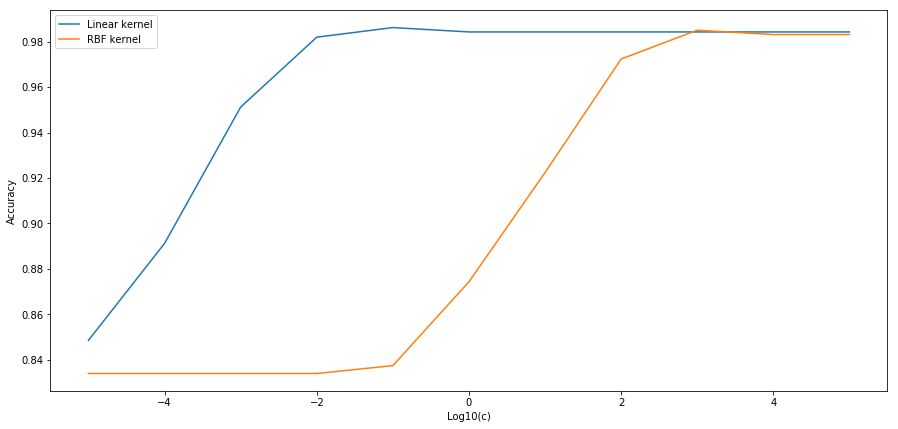

In [13]:
# Now we plot the accuracies to show which hyperparameters are better:
means_linear = []
means_rbf = []

for c in cs:
    means_linear.append(np.mean(SMV_results[0][c]))
    means_rbf.append(np.mean(SMV_results[1][c]))

x_axis = np.log10(np.array(cs))

fig = plt.figure(figsize=(15,7))
plt.plot(x_axis, means_linear, label='Linear kernel')
plt.plot(x_axis, means_rbf, label='RBF kernel')
plt.xlabel("Log10(c)")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('svm.png')
plt.show()

In [14]:
### Now we proceed to select the best SVM out of the ones tried in the previous cells ###
### This is: linear kernel for C = 0.1 ###

# We create the model and fit it:
SVM_final_classifier = Pipeline([('vectorizer', CountVectorizer()), ('svm', svm.SVC(C=0.01, kernel='linear'))])
SVM_final_classifier.fit(data_train['X'], data_train['y'].tolist());

In [15]:
# Store accuracy, precision and recall:
results_SVM = []
y_test_pred = SVM_final_classifier.predict(data_test['X'])
results_SVM.append(accuracy_score(data_test['y'].tolist(), y_test_pred))
results_SVM.append(precision_score(data_test['y'].tolist(), y_test_pred))
results_SVM.append(recall_score(data_test['y'].tolist(), y_test_pred))

In [16]:
# Show results [accuracy, precision, recall]:
results_SVM

[0.97250859106529208, 0.93617021276595747, 0.89795918367346939]